In [76]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git
# !pip install matplotlib pandas
# !pip3 install torch torchvision torchaudio

In [77]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
from torchmetrics.classification import BinaryAUROC


print("Torch version:", torch.__version__)


Torch version: 1.13.0+cu117


In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [79]:
# !unzip -o -q ./hateful_memes.zip -d $HOME/.cache/torch/mmf/data/datasets/

In [80]:
# !mkdir -p $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/{images,annotations}
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/img/* $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/*.jsonl $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/

### Load Hateful Meme Dataset

In [81]:
import pandas as pd
import os

HOME = os.environ.get("HOME")
images_path = f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/"
annotations_path = f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/"

train = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
dev_seen = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
dev_unseen = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
test_seen = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)


In [82]:
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [83]:
# # Collect all the annotations (from Phase-2)
# train       = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
# dev_seen    = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
# dev_unseen  = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
# test_seen   = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
# test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)

# Create 2 sets: 
#   A set of strings, 'a': for all the image names,
#   A set of lists, 'b': for all the image names in dataset, e.g. train, dev_seen, etc.
a = os.listdir(f"{images_path}")
b = []
for i in [train, dev_seen, dev_unseen, test_seen, test_unseen]:
    b.append(list(i["img"].str.split("/").str.get(1)))

set_mapping = ['train', 'dev_seen', 'dev_unseen', 'test_seen', 'test_unseen']
total_size = 0
print("#of images in: ")
for idx, i in enumerate(b):
    total_size += len(set(i))
    print(f"\t'{set_mapping[idx]}'  \t:", len(set(i)))
else:
    print(f"\nIn total there are {total_size} images,",
          "\nBut the # of images in /img/ directory is: ", len(a))

#of images in: 
	'train'  	: 8500
	'dev_seen'  	: 500
	'dev_unseen'  	: 540
	'test_seen'  	: 1000
	'test_unseen'  	: 2000

In total there are 12540 images, 
But the # of images in /img/ directory is:  12469


In [84]:
print("#of images that are not in one of the .jsonl files: ", 
      len(set(a).symmetric_difference(set(b[0] + b[1] + b[2] + b[3] + b[4]))))

#of images that are not in one of the .jsonl files:  329


In [85]:
print("#of same images in between: ")
for i in range(0, 5):
    print("\n")
    for j in range(0, 5):
        if i != j:
            print(f"{set_mapping[i], set_mapping[j]}   \t: {len(set(b[i]) & set(b[j]))}")

#of same images in between: 


('train', 'dev_seen')   	: 0
('train', 'dev_unseen')   	: 0
('train', 'test_seen')   	: 0
('train', 'test_unseen')   	: 0


('dev_seen', 'train')   	: 0
('dev_seen', 'dev_unseen')   	: 400
('dev_seen', 'test_seen')   	: 0
('dev_seen', 'test_unseen')   	: 0


('dev_unseen', 'train')   	: 0
('dev_unseen', 'dev_seen')   	: 400
('dev_unseen', 'test_seen')   	: 0
('dev_unseen', 'test_unseen')   	: 0


('test_seen', 'train')   	: 0
('test_seen', 'dev_seen')   	: 0
('test_seen', 'dev_unseen')   	: 0
('test_seen', 'test_unseen')   	: 0


('test_unseen', 'train')   	: 0
('test_unseen', 'dev_seen')   	: 0
('test_unseen', 'dev_unseen')   	: 0
('test_unseen', 'test_seen')   	: 0


`dev_seen` has 100 images not in `dev_unseen`. Merging the 100 images to the train data as follows:

In [86]:
dev_seen.head()

img_100 = set(dev_seen["img"]).difference(dev_unseen["img"])
train_updated = pd.concat([train, dev_seen[dev_seen["img"].isin(img_100)]])
train_updated.to_json(f"{annotations_path}/train_updated.jsonl", orient="records", lines=True)
train.shape, train_updated.shape

((8500, 4), (8600, 4))

## Write the dataset class

In [87]:
train.head(1)

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters


In [88]:
class HMDataset(Dataset):
    def __init__(self, images_path: str, annotation_path: str, image_transform=None, text_transform=None) -> None:
        self.images_path = images_path
        self.annotation_path = annotation_path
        self.image_transform = image_transform
        self.text_transform = text_transform
        assert self.annotation_path.endswith(".jsonl"), f"Invalid annotation file format. Format should be '.jsonl', not {self.annotation_path.split('.')[0]}"
        self.annotation: pd.DataFrame = pd.read_json(self.annotation_path, lines=True)      

    def __len__(self):
        return self.annotation.shape[0]

    def __getitem__(self, index):
        img_path = os.path.join(self.images_path, self.annotation.loc[index,"img"])
        image = Image.open(img_path).convert("RGB")
        text = self.annotation.loc[index,"text"]
        label = self.annotation.loc[index,"label"]
        if self.image_transform:
            image = self.image_transform(image)
        if self.text_transform:
            text = self.text_transform(text)
        return image, text, torch.tensor(label)

In [89]:
hm_dataset = HMDataset(images_path, f"{annotations_path}/train_updated.jsonl", )
len(hm_dataset)

8600

In [90]:
import clip

clip.available_models()


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [91]:
model, preprocess = clip.load("ViT-B/32")
model, preprocess = clip.load("ViT-L/14@336px")
model.to(device).eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


In [92]:
preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x7fbe948801f0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [93]:
clip.tokenize("This is awesome really"*20, truncate=True)

tensor([[49406,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 49407]], dtype=torch.int32)

In [94]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image

from collections import OrderedDict

/tmp/ipykernel_181566/3921464836.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 8600 + 1) instead
  for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):


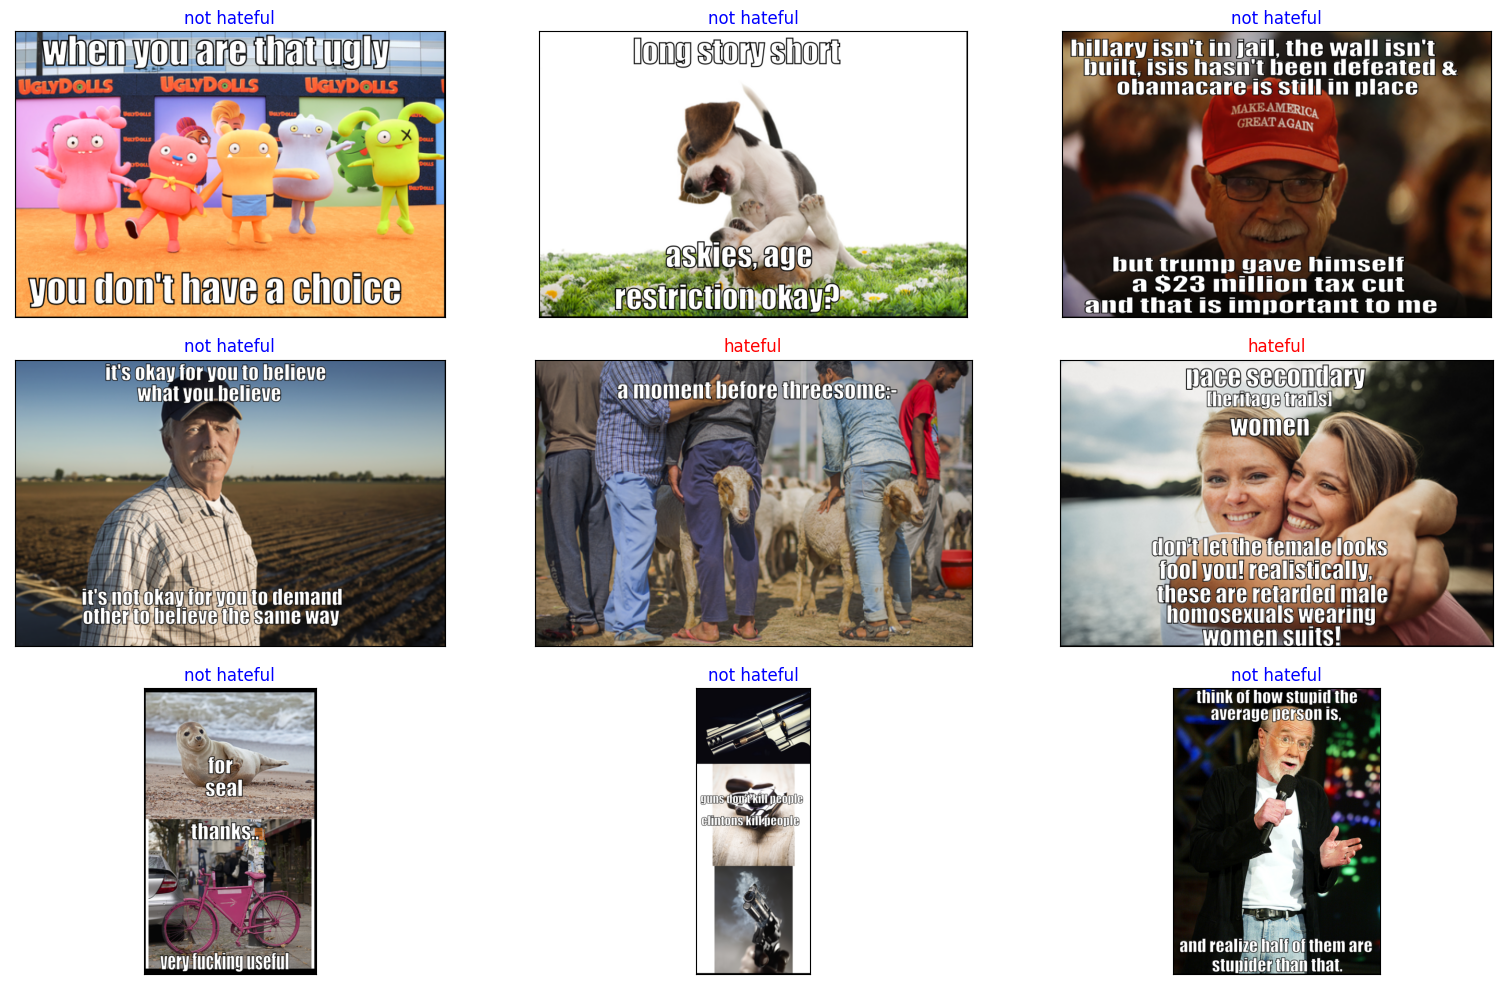

In [95]:
hm_dataset = HMDataset(images_path, f"{annotations_path}/train_updated.jsonl", image_transform=None)

plt.figure(figsize=(16, 10))

label_map = {1:"hateful", 0:"not hateful"}

for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):
    image, text, label = hm_dataset[idx]

    plt.subplot(3, 3, i+1)
    # C, W, H = image.shape
    # image = image.convert("RGB")
    plt.imshow(image)
    plt.title(label_map[label.item()], color="r" if label else "b")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

In [106]:
import torch.nn as nn
import torch.nn.functional as F

class HMMLP(nn.Module):

    def __init__(self, n_in=768*2, n_out=1, ) -> None:
        super().__init__()

        self.fc1 = nn.Linear(n_in, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, n_out)

    def forward(self, x):
        
        # x = self.fc1(x)
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        x = self.fc4(x)

        return x

In [107]:
batch_size = 32

def text_preprocess(text):
    return clip.tokenize(text, truncate=True)

hm_train_dataset = HMDataset(images_path, f"{annotations_path}/train_updated.jsonl", image_transform=preprocess, text_transform=text_preprocess)
hm_test_dataset = HMDataset(images_path, f"{annotations_path}/test_unseen.jsonl", image_transform=preprocess, text_transform=text_preprocess)
hm_val_dataset = HMDataset(images_path, f"{annotations_path}/dev_unseen.jsonl", image_transform=preprocess, text_transform=text_preprocess)

train_dataloader = DataLoader(hm_train_dataset, batch_size=batch_size, shuffle=True, num_workers=26)
test_dataloader = DataLoader(hm_test_dataset, batch_size=batch_size, shuffle=True, num_workers=26)
val_dataloader = DataLoader(hm_val_dataset, batch_size=batch_size, shuffle=True, num_workers=26)

In [108]:
data = next(iter(train_dataloader))

In [109]:
images, texts, labels = data
images.shape, texts.shape, labels.shape

(torch.Size([32, 3, 336, 336]), torch.Size([32, 1, 77]), torch.Size([32]))

In [110]:
net = HMMLP()
images, texts, labels = data
images = images.to(device)
texts = texts.to(device)
labels = labels.to(device).float()

with torch.no_grad():
    images = model.encode_image(images)
    texts = model.encode_text(texts.squeeze())

In [111]:
images.shape, texts.shape, labels.shape

(torch.Size([32, 768]), torch.Size([32, 768]), torch.Size([32]))

In [112]:
net = net.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer.zero_grad()

In [113]:
fused = torch.hstack((images,texts))
fused.requires_grad

False

In [114]:
fused.requires_grad_()
fused.requires_grad

True

In [115]:
output = net(fused.float())

In [116]:
output.shape, labels.shape

(torch.Size([32, 1]), torch.Size([32]))

In [117]:
labels.squeeze()

tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       device='cuda:0')

In [118]:
output.squeeze(), labels.squeeze()

(tensor([-0.2572, -0.2622, -0.2619, -0.2555, -0.2654, -0.2692, -0.2597, -0.2598,
         -0.2583, -0.2498, -0.2608, -0.2544, -0.2646, -0.2572, -0.2609, -0.2563,
         -0.2573, -0.2614, -0.2535, -0.2594, -0.2609, -0.2624, -0.2516, -0.2626,
         -0.2653, -0.2577, -0.2620, -0.2677, -0.2502, -0.2678, -0.2570, -0.2672],
        device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        device='cuda:0'))

In [119]:
o = output.squeeze().round()

In [120]:
sum(o==labels)

tensor(20, device='cuda:0')

In [121]:
loss = criterion(output.squeeze(), labels.squeeze())
loss.backward()
optimizer.step()

In [123]:
from tqdm import tqdm
net = HMMLP()
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

epochs = 10
print_every = 50

for epoch in range(epochs):
    
    running_loss = 0
    for i, data in enumerate(tqdm(train_dataloader), 0):
        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.float().squeeze().to(device)

        with torch.no_grad():
            images = model.encode_image(images) # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
            texts = model.encode_text(texts.squeeze()) # input_dim: batch_size x 77; output_dim: batch_size x 512
        
        fused_images_texts = torch.hstack((images,texts))
        fused_images_texts.requires_grad_()
        fused_images_texts = fused_images_texts.float()

        optimizer.zero_grad()

        # Forward pass on the fused data

        output = net(fused_images_texts)

        loss = criterion(output.squeeze(), labels)

        # Compute gradient
        loss.backward()
        # Update weight
        optimizer.step()

        running_loss += loss.item()

        if i%print_every==(print_every - 1): 
            
            print(f"[Epoch {epoch + 1}, step {i+1:3d}] loss: {running_loss/print_every:.5f}")
            running_loss = 0.0

    ## Switch to eval mode
    net.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    preds_all_val = torch.tensor([]).cuda()
    labels_all_val = torch.tensor([]).cuda()
    for i, data in enumerate(val_dataloader, 0):
        
        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.float().squeeze().to(device)

        with torch.no_grad():
            images = model.encode_image(images) # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
            texts = model.encode_text(texts.squeeze()) # input_dim: batch_size x 77; output_dim: batch_size x 512
        
        fused_images_texts = torch.hstack((images,texts))
        fused_images_texts.requires_grad_()
        fused_images_texts = fused_images_texts.float()

        with torch.no_grad():
            output = net(fused_images_texts)

        loss = criterion(output.squeeze(), labels)

        running_loss += loss.item()

        correct_preds += sum(torch.sigmoid(output).squeeze().round()==labels)
        total_preds += len(labels)

        preds_all_val = torch.cat((preds_all_val, torch.sigmoid(output).squeeze()))
        labels_all_val = torch.cat((labels_all_val, labels))

    auroc = BinaryAUROC()
    auroc_score = auroc(preds_all_val, labels_all_val.int())

    print(f"\n[Epoch {epoch +1}, step {i+1:3d}] val loss: {running_loss/i+1:.5f} "
    f"accuracy: {torch.mean(preds_all_val.round()==labels_all_val, dtype=torch.float32)} auroc: {auroc_score}\n")
    # f"accuracy: {correct_preds/total_preds} auroc: {auroc_score}\n")

    
print("Finished Training!")
        

 19%|█▊        | 50/269 [00:38<02:33,  1.43it/s]

[Epoch 1, step  50] loss: 0.60948


 37%|███▋      | 100/269 [01:14<02:01,  1.39it/s]

[Epoch 1, step 100] loss: 0.52901


 56%|█████▌    | 150/269 [01:40<00:58,  2.03it/s]

[Epoch 1, step 150] loss: 0.47285


 74%|███████▍  | 200/269 [02:05<00:34,  2.01it/s]

[Epoch 1, step 200] loss: 0.49946


 93%|█████████▎| 250/269 [02:29<00:09,  2.04it/s]

[Epoch 1, step 250] loss: 0.45941


100%|██████████| 269/269 [02:40<00:00,  1.67it/s]



[Epoch 1, step  17] val loss: 1.71549 accuracy: 0.6814814805984497 auroc: 0.6898823380470276



 19%|█▊        | 50/269 [00:39<02:35,  1.41it/s]

[Epoch 2, step  50] loss: 0.38921


 37%|███▋      | 100/269 [01:14<02:07,  1.33it/s]

[Epoch 2, step 100] loss: 0.42165


 56%|█████▌    | 150/269 [01:49<01:19,  1.49it/s]

[Epoch 2, step 150] loss: 0.40921


 74%|███████▍  | 200/269 [02:25<00:47,  1.44it/s]

[Epoch 2, step 200] loss: 0.39752


 93%|█████████▎| 250/269 [03:00<00:12,  1.48it/s]

[Epoch 2, step 250] loss: 0.41148


100%|██████████| 269/269 [03:13<00:00,  1.39it/s]



[Epoch 2, step  17] val loss: 1.64268 accuracy: 0.6851851940155029 auroc: 0.7317941188812256



 19%|█▊        | 50/269 [00:39<02:41,  1.36it/s]

[Epoch 3, step  50] loss: 0.31979


 37%|███▋      | 100/269 [01:14<01:52,  1.50it/s]

[Epoch 3, step 100] loss: 0.33825


 56%|█████▌    | 150/269 [01:49<01:28,  1.34it/s]

[Epoch 3, step 150] loss: 0.34355


 74%|███████▍  | 200/269 [02:24<00:45,  1.52it/s]

[Epoch 3, step 200] loss: 0.34161


 93%|█████████▎| 250/269 [02:59<00:13,  1.44it/s]

[Epoch 3, step 250] loss: 0.36441


100%|██████████| 269/269 [03:12<00:00,  1.40it/s]



[Epoch 3, step  17] val loss: 1.65955 accuracy: 0.6833333373069763 auroc: 0.7484853267669678



 19%|█▊        | 50/269 [00:42<02:25,  1.51it/s]

[Epoch 4, step  50] loss: 0.27131


 37%|███▋      | 100/269 [01:17<01:48,  1.56it/s]

[Epoch 4, step 100] loss: 0.26545


 56%|█████▌    | 150/269 [01:52<01:23,  1.43it/s]

[Epoch 4, step 150] loss: 0.26555


 74%|███████▍  | 200/269 [02:27<00:50,  1.38it/s]

[Epoch 4, step 200] loss: 0.27899


 93%|█████████▎| 250/269 [03:02<00:13,  1.41it/s]

[Epoch 4, step 250] loss: 0.23540


100%|██████████| 269/269 [03:15<00:00,  1.38it/s]



[Epoch 4, step  17] val loss: 1.71219 accuracy: 0.690740704536438 auroc: 0.7519558668136597



 19%|█▊        | 50/269 [00:39<02:29,  1.46it/s]

[Epoch 5, step  50] loss: 0.16130


 37%|███▋      | 100/269 [01:14<02:03,  1.36it/s]

[Epoch 5, step 100] loss: 0.19185


 56%|█████▌    | 150/269 [01:49<01:30,  1.32it/s]

[Epoch 5, step 150] loss: 0.23220


 74%|███████▍  | 200/269 [02:25<00:51,  1.33it/s]

[Epoch 5, step 200] loss: 0.25298


 93%|█████████▎| 250/269 [03:00<00:14,  1.31it/s]

[Epoch 5, step 250] loss: 0.21009


100%|██████████| 269/269 [03:13<00:00,  1.39it/s]



[Epoch 5, step  17] val loss: 1.82960 accuracy: 0.6851851940155029 auroc: 0.734573483467102



 19%|█▊        | 50/269 [00:39<03:09,  1.16it/s]

[Epoch 6, step  50] loss: 0.15414


 37%|███▋      | 100/269 [01:17<01:52,  1.51it/s]

[Epoch 6, step 100] loss: 0.14127


 56%|█████▌    | 150/269 [01:50<01:15,  1.59it/s]

[Epoch 6, step 150] loss: 0.15717


 74%|███████▍  | 200/269 [02:21<00:42,  1.62it/s]

[Epoch 6, step 200] loss: 0.15432


 93%|█████████▎| 250/269 [02:52<00:11,  1.63it/s]

[Epoch 6, step 250] loss: 0.16159


100%|██████████| 269/269 [03:04<00:00,  1.46it/s]



[Epoch 6, step  17] val loss: 1.99407 accuracy: 0.6759259104728699 auroc: 0.747426450252533



 19%|█▊        | 50/269 [00:34<02:13,  1.65it/s]

[Epoch 7, step  50] loss: 0.13583


 37%|███▋      | 100/269 [01:05<01:37,  1.74it/s]

[Epoch 7, step 100] loss: 0.09527


 56%|█████▌    | 150/269 [01:36<01:21,  1.45it/s]

[Epoch 7, step 150] loss: 0.09636


 74%|███████▍  | 200/269 [02:07<00:40,  1.69it/s]

[Epoch 7, step 200] loss: 0.13187


 93%|█████████▎| 250/269 [02:39<00:12,  1.57it/s]

[Epoch 7, step 250] loss: 0.10294


100%|██████████| 269/269 [02:51<00:00,  1.57it/s]



[Epoch 7, step  17] val loss: 2.42687 accuracy: 0.6888888478279114 auroc: 0.7432794570922852



 19%|█▊        | 50/269 [00:34<02:10,  1.68it/s]

[Epoch 8, step  50] loss: 0.07152


 37%|███▋      | 100/269 [01:06<01:42,  1.64it/s]

[Epoch 8, step 100] loss: 0.09074


 56%|█████▌    | 150/269 [01:40<01:46,  1.12it/s]

[Epoch 8, step 150] loss: 0.07900


 74%|███████▍  | 200/269 [02:12<00:42,  1.62it/s]

[Epoch 8, step 200] loss: 0.10095


 93%|█████████▎| 250/269 [02:43<00:12,  1.57it/s]

[Epoch 8, step 250] loss: 0.13170


100%|██████████| 269/269 [02:55<00:00,  1.53it/s]



[Epoch 8, step  17] val loss: 2.20350 accuracy: 0.6925925612449646 auroc: 0.746720552444458



 19%|█▊        | 50/269 [00:34<02:19,  1.57it/s]

[Epoch 9, step  50] loss: 0.06668


 37%|███▋      | 100/269 [01:05<01:47,  1.57it/s]

[Epoch 9, step 100] loss: 0.06051


 56%|█████▌    | 150/269 [01:37<01:12,  1.65it/s]

[Epoch 9, step 150] loss: 0.09087


 74%|███████▍  | 200/269 [02:08<00:40,  1.71it/s]

[Epoch 9, step 200] loss: 0.07680


 93%|█████████▎| 250/269 [02:39<00:12,  1.51it/s]

[Epoch 9, step 250] loss: 0.10317


100%|██████████| 269/269 [02:51<00:00,  1.57it/s]



[Epoch 9, step  17] val loss: 2.38248 accuracy: 0.6722221970558167 auroc: 0.7389117479324341



 19%|█▊        | 50/269 [00:34<02:22,  1.54it/s]

[Epoch 10, step  50] loss: 0.07079


 37%|███▋      | 100/269 [01:05<01:41,  1.67it/s]

[Epoch 10, step 100] loss: 0.04509


 56%|█████▌    | 150/269 [01:36<01:12,  1.63it/s]

[Epoch 10, step 150] loss: 0.09379


 74%|███████▍  | 200/269 [02:08<00:45,  1.51it/s]

[Epoch 10, step 200] loss: 0.06384


 93%|█████████▎| 250/269 [02:42<00:14,  1.33it/s]

[Epoch 10, step 250] loss: 0.09229


100%|██████████| 269/269 [02:54<00:00,  1.54it/s]



[Epoch 10, step  17] val loss: 2.69674 accuracy: 0.7074074149131775 auroc: 0.7493382692337036

Finished Training!
